In [20]:
# Load the video data 
import numpy as np
import skvideo.io
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from tqdm import tqdm
from queue import Queue
import pickle
import pandas as pd
import xarray as xr
%matplotlib inline

In [15]:
filename = "sample.mp4" 
frames_to_load = 7273 # this is necessary because it seems to crash at the end of the video 

moviedata = skvideo.io.vread(filename, num_frames=frames_to_load)

print(moviedata.shape)

(7273, 384, 384, 3)


In [29]:
# So all color channels contain the same data. I think we can safely drop all the extra channels. I also think we can crop a bit, maybe 50 pixels off each side.
crop = 50
test_frames = 40

ds = xr.Dataset()
ds["raw"] = (("t", "x", "y"), moviedata[:test_frames, crop:-crop, crop:-crop, 0])

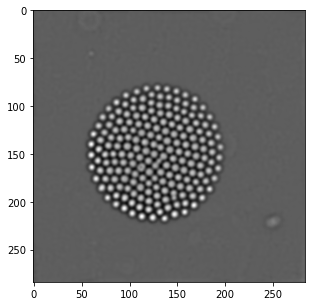

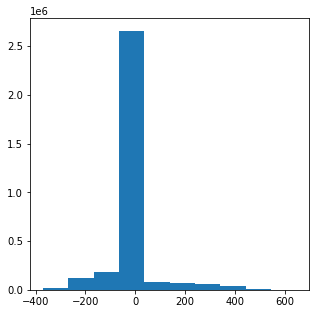

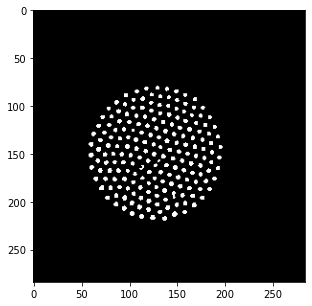

In [35]:
# let's try the top hat filter, per our discussion in class.

# filter_scale = 3.5 ## in pixels
# threshold = 1000
filter_scale = 3
threshold = 200

# plt.figure(figsize=(5, 5))
# plt.imshow(data[0, :, :], "gray")
# plt.show()

[N, X, Y] = ds.raw.shape
x = np.arange(-X/2, X/2)
y = np.arange(-Y/2, Y/2)
#print(np.size(x),np.size(y))
x2d, y2d = np.meshgrid(y, x)
radius = np.sqrt(x2d**2 + y2d**2)
real_space_filter = np.exp(-2 * (radius / filter_scale)**2) * (1 - 2 * (radius / filter_scale)**4)
# plt.figure(figsize=(5, 5))
# plt.imshow(real_space_filter)
# plt.show()

fft_data = np.fft.fft2(ds.raw, axes=[1, 2])
fourier_filter = np.fft.fft2(np.fft.fftshift(real_space_filter))
ds["filtered"] = (("t", "x", "y"), np.real(np.fft.ifft2(fft_data*fourier_filter)))
plt.figure(figsize=(5, 5))
plt.imshow(ds.filtered.isel(t=0), "gray")
plt.show()

plt.figure(figsize=(5, 5))
plt.hist(np.ravel(ds.filtered))
plt.show()

thresh = np.copy(ds.filtered)
thresh[thresh < threshold] = 0
thresh[thresh > 0] = 1
ds["binary"] = (("t", "x", "y"), np.asarray(thresh, dtype=bool))
plt.figure(figsize=(5, 5))
plt.imshow(ds.binary.isel(t=0), "gray")
plt.show()

In [41]:
# do smarter particle assignment
# from https://en.wikipedia.org/wiki/Connected-component_labeling

def check_adjacent(i, j, data, status, q):
    # process adjacent pixels and add them to the queue if need be 
    if not status[i, j+1]:
        if data[i, j+1]:
            q.put([i, j+1])
        else: 
            status[i, j+1] = True

def find_connected_components(data):
    [X, Y] = data.shape
    curr = 0
    labels = np.zeros_like(data, dtype=int) - 1
    status = np.zeros_like(data, dtype=bool)
    q1 = Queue()
    q2 = Queue()
    for i in range(X):
        for j in range(Y):

            # skip this pixel if we already got it
            if status[i, j]:
                continue

            # if this pixel is false, flag it as processed and continue
            if not data[i, j]:
                status[i, j] = True
                continue
        
            # check adjacent pixels and add them to the queue if needed 
            check_adjacent(i, j+1, data, status, q1)
            check_adjacent(i, j-1, data, status, q1)
            check_adjacent(i+1, j, data, status, q1)
            check_adjacent(i-1, j, data, status, q1)
            labels[i, j] = curr
            status[i, j] = True
            # process the queue
            while not q1.empty():
                [a, b] = q1.get()
                check_adjacent(a, b+1, data, status, q2)
                check_adjacent(a, b-1, data, status, q2)
                check_adjacent(a+1, b, data, status, q2)
                check_adjacent(a-1, b, data, status, q2)
                labels[a, b] = curr
                status[a, b] = True
                while not q2.empty():
                    q1.put(q2.get())
            curr += 1

    return labels, curr-1

ds["particle"] = (("t", "x", "y"), np.zeros_like(ds.raw, dtype=int))
ds["n_particles"] = (("t"), np.zeros_like(ds.raw.coords["t"].values, dtype=int))

for t in ds.coords["t"].values:
    l, n = find_connected_components(ds.binary.isel(t=0))
    ds.particle.loc[dict(t=t)] = l
    ds.n_particles.loc[dict(t=t)] = n

TypeError: 'DataArray' object cannot be interpreted as an integer

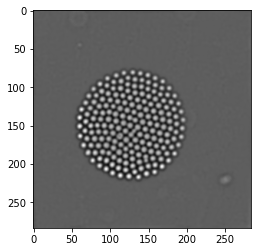

In [48]:
plt.figure()
plt.imshow(ds.filtered.isel(t=0), "gray")
for i in range(ds.n_particles.isel(t=0)):
    p = xr.where(ds.particle.iself(t=0) == i)
    print(p)
plt.show()